# Notebook to download and process CHIRPS data for cyclones

In [ ]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import geopandas as gpd
import gzip
import shutil
import rasterio
import geopandas as gpd
from datetime import timedelta

from rasterio.mask import mask
from src.datasources import codab, rsmc
from src.constants import *
from src.utils import *

In [ ]:
save_dir = AA_DATA_DIR / "public" / "raw" / "moz" / "chirps" / "daily"

In [20]:
adm1_path = (
    AA_DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)

gdf_adm1 = gpd.read_file(adm1_path)
gdf_adm1_sel = codab.load_codab(aoi_only=True)

In [118]:
rain_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "daily_imerg_cyclone_landfall_fixed.csv"
)

In [120]:
landfall_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location.csv"
)

<Axes: >

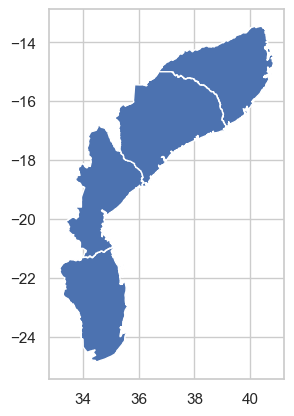

In [121]:
gdf_adm1_sel.plot()

In [130]:
kenneth_df = rain_df[(rain_df["storm"] == "KENNETH") & (rain_df["time_step"].isin([-2, -1]))]

In [131]:
kenneth_df

,Unnamed: 0,storm,date,time_step,radius,median_precip
960,960,KENNETH,23/04/2019 15:00,-2,50,NaN
961,961,KENNETH,23/04/2019 15:00,-2,100,NaN
962,962,KENNETH,23/04/2019 15:00,-2,150,0.000912
963,963,KENNETH,23/04/2019 15:00,-2,200,0.005736
964,964,KENNETH,23/04/2019 15:00,-2,250,0.001962
965,965,KENNETH,23/04/2019 15:00,-2,300,0.000182
966,966,KENNETH,23/04/2019 15:00,-2,350,0.000000
967,967,KENNETH,23/04/2019 15:00,-2,400,0.000000
968,968,KENNETH,23/04/2019 15:00,-2,450,0.000000
969,969,KENNETH,23/04/2019 15:00,-2,500,0.000000


In [ ]:

# URL format for downloading CHIRPS tif files
base_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/p05"

# Iterate over the DataFrame and download files based on dates
for date in tqdm(kenneth_df["date"].unique()):
    # Convert the date to the format used in the URL
    date_str = pd.to_datetime(date).strftime('%Y.%m.%d')
    year_dt = pd.to_datetime(date).year
    tif_url = f"{base_url}/{year_dt}/chirps-v2.0.{date_str}.tif.gz"
    
    # Download the .tif.gz file
    download_unzip_and_crop_tif(tif_url, save_dir, gdf_adm1)


In [136]:
chirps_files = [os.path.join(save_dir, f) for f in os.listdir(save_dir)]

In [ ]:
# Initialize the output DataFrame
output_df = pd.DataFrame(
    columns=["NAME", "date", "days_to_landfall", "median_rainfall"]
)

# Define the number of days to look around each point's date
days_range = 14  # Adjust this as needed

# Loop through each cyclone (NAME)
for cyclone in landfall_df["NAME"].unique():
    cyclone_df = landfall_df[landfall_df["NAME"] == cyclone].copy()
    cyclone_df["date"] = pd.to_datetime(cyclone_df["date"], dayfirst=True)

    # Find the landfall date (the date when 'actual_within_land' is True)
    landfall_date = cyclone_df[cyclone_df["actual_within_land"]].iloc[0][
        "date"
    ]

    # Process each date for the cyclone
    for index, row in cyclone_df.iterrows():
        # Determine the date range to search for TIF files
        start_date = row["date"] - timedelta(days=days_range)
        end_date = row["date"] + timedelta(days=days_range)

        # Loop through all TIF files in inam_path
        for tif_file in os.listdir(save_dir):
            # Extract date from TIF filename assuming 'chirp_daily_blended_moz_YYYYMMDD.tif' format
            tif_date_str = tif_file.split("chirps-v2.0.")[-1].split(".tif")[0]
            tif_date = pd.to_datetime(tif_date_str, format="%Y.%m.%d")

            # Process the TIF file if its date falls within the desired range
            if start_date <= tif_date <= end_date:
                tif_path = os.path.join(save_dir, tif_file)

                # Compute the median rainfall within the 250km radius
                median_rainfall = get_median_rainfall(
                    tif_path, row["LON"], row["LAT"], 250, gdf_adm1_sel
                )

                # Calculate days to landfall
                days_to_landfall = (tif_date - landfall_date).days

                # Create a temporary DataFrame to store the result
                temp_df = pd.DataFrame(
                    {
                        "NAME": [cyclone],
                        "date": [tif_date],  # Use TIF file's date here
                        "days_to_landfall": [
                            days_to_landfall
                        ],  # Calculate days to landfall
                        "median_rainfall": [median_rainfall],
                    }
                )

                # Append the temporary DataFrame to the output DataFrame using pd.concat
                output_df = pd.concat([output_df, temp_df], ignore_index=True)

In [140]:
output_df

,NAME,date,days_to_landfall,median_rainfall
0,FAVIO,2007-02-20,-2,0.000000
1,FAVIO,2007-02-21,-1,0.000000
2,FAVIO,2007-02-22,0,34.304848
3,FAVIO,2007-02-23,1,20.767479
4,FAVIO,2007-02-24,2,8.620152
...,...,...,...,...
181,FILIPO,2024-03-13,1,0.000000
182,FILIPO,2024-03-14,2,0.000000
183,FILIPO,2024-03-15,3,28.359436
184,FILIPO,2024-03-16,4,0.000000


In [141]:
output_df.to_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "daily_chirps_cyclone_landfall_fixed.csv"
)